In [65]:
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline 
import pandas as pd
import sys
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Ellipse
import seaborn as sns
from torch.utils.data import random_split

sys.path.insert(1, os.path.dirname(os.getcwd()) + "/utils/")
from utils.plotting import make_vae_plots,plot_2d_latents
from utils.snp_dataset import snp_Dataset
from utils.vae_dists import ReparameterizedDiagonalGaussian
from utils.modules import VariationalAutoencoder, Classifier

In [2]:
#Loading The 1KG data
data_1kg = np.load('data_1kg.npy')
labels_1kg = np.load('labels_1kg.npy',allow_pickle=True)

In [3]:
#Making training and test sets
dataset = snp_Dataset(data_1kg,labels_1kg)
size_test = round(len(dataset)*15/100)
size_train = len(dataset)-size_test
train_data, test_data = random_split(dataset, [size_train, size_test])

In [4]:
# cmap for plotting
cmap = {label:i for i,label in enumerate(set(dataset.labels))}

In [5]:
# Make data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16,
                                           shuffle = True, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32,
                                           shuffle = True, num_workers = 0)

In [9]:
# define the first vae model, evaluator and optimizer
from collections import defaultdict

# popVAE
latent_features = 2
hidden_layers = 5
layer_widths = [1024,512,256,128,64]
vae = VariationalAutoencoder(len(dataset[0][0]), 
                             latent_features,
                             hidden_layers,
                             width = (layer_widths,
                                      layer_widths[::-1]),
                             batch_norm=True,
                             flow=True)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

Finished epoch 165 with validation loss 4686504.0, current beta 40


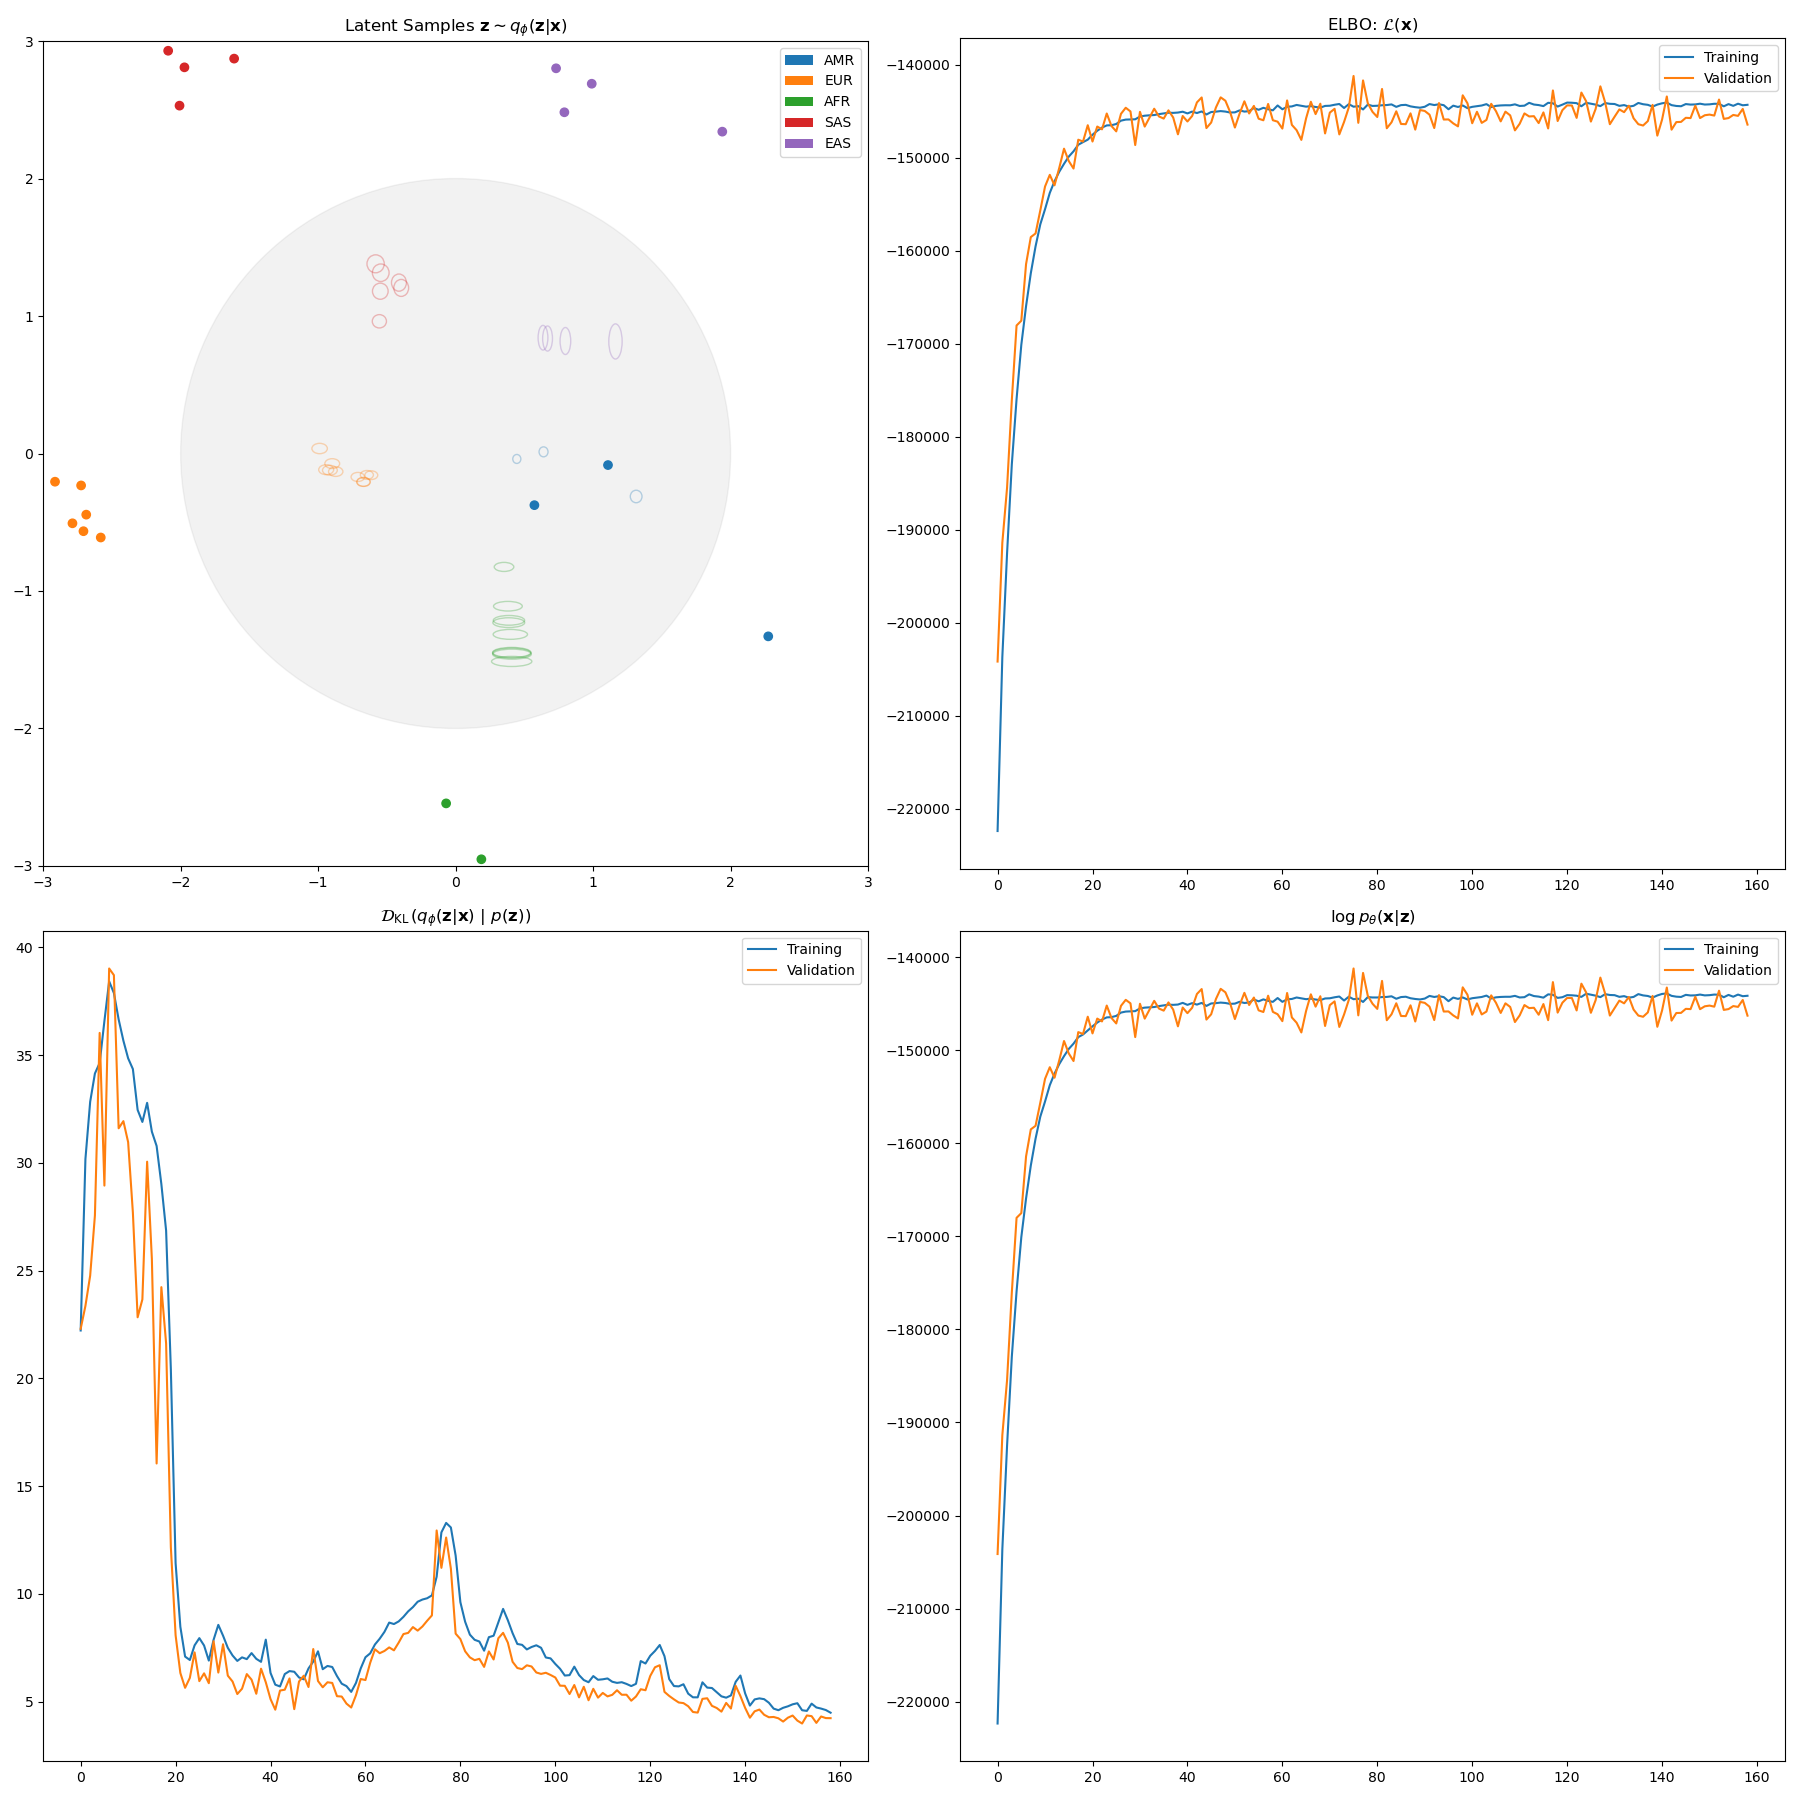

In [24]:
#%%Run the VAE training loop
num_epochs = 165
beta_schedule = [1,10,20,1,10,20,30,40]
beta_duration = num_epochs/len(beta_schedule)
#beta_i = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    torch.cuda.empty_cache()
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()
    if epoch % beta_duration == 0:
        beta_i += 1
    beta = beta_schedule[7]
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, outputs, diagnostics = vae(x,beta=beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.item()/len(x)]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, outputs, diagnostics = vae(x, beta=beta)
        outputs['qz'] = ReparameterizedDiagonalGaussian(outputs['mean'], 0.5*outputs['logvar'])
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.item()/len(x)]

        print(f"Finished epoch {epoch} with validation loss {loss}, current beta {beta}")
        # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
        make_vae_plots(vae, x, y, outputs, training_data, validation_data, cmap=cmap)    

In [27]:
save_popvae = False
if save_popvae:
    torch.save(vae.state_dict(), 'popvae.pt')

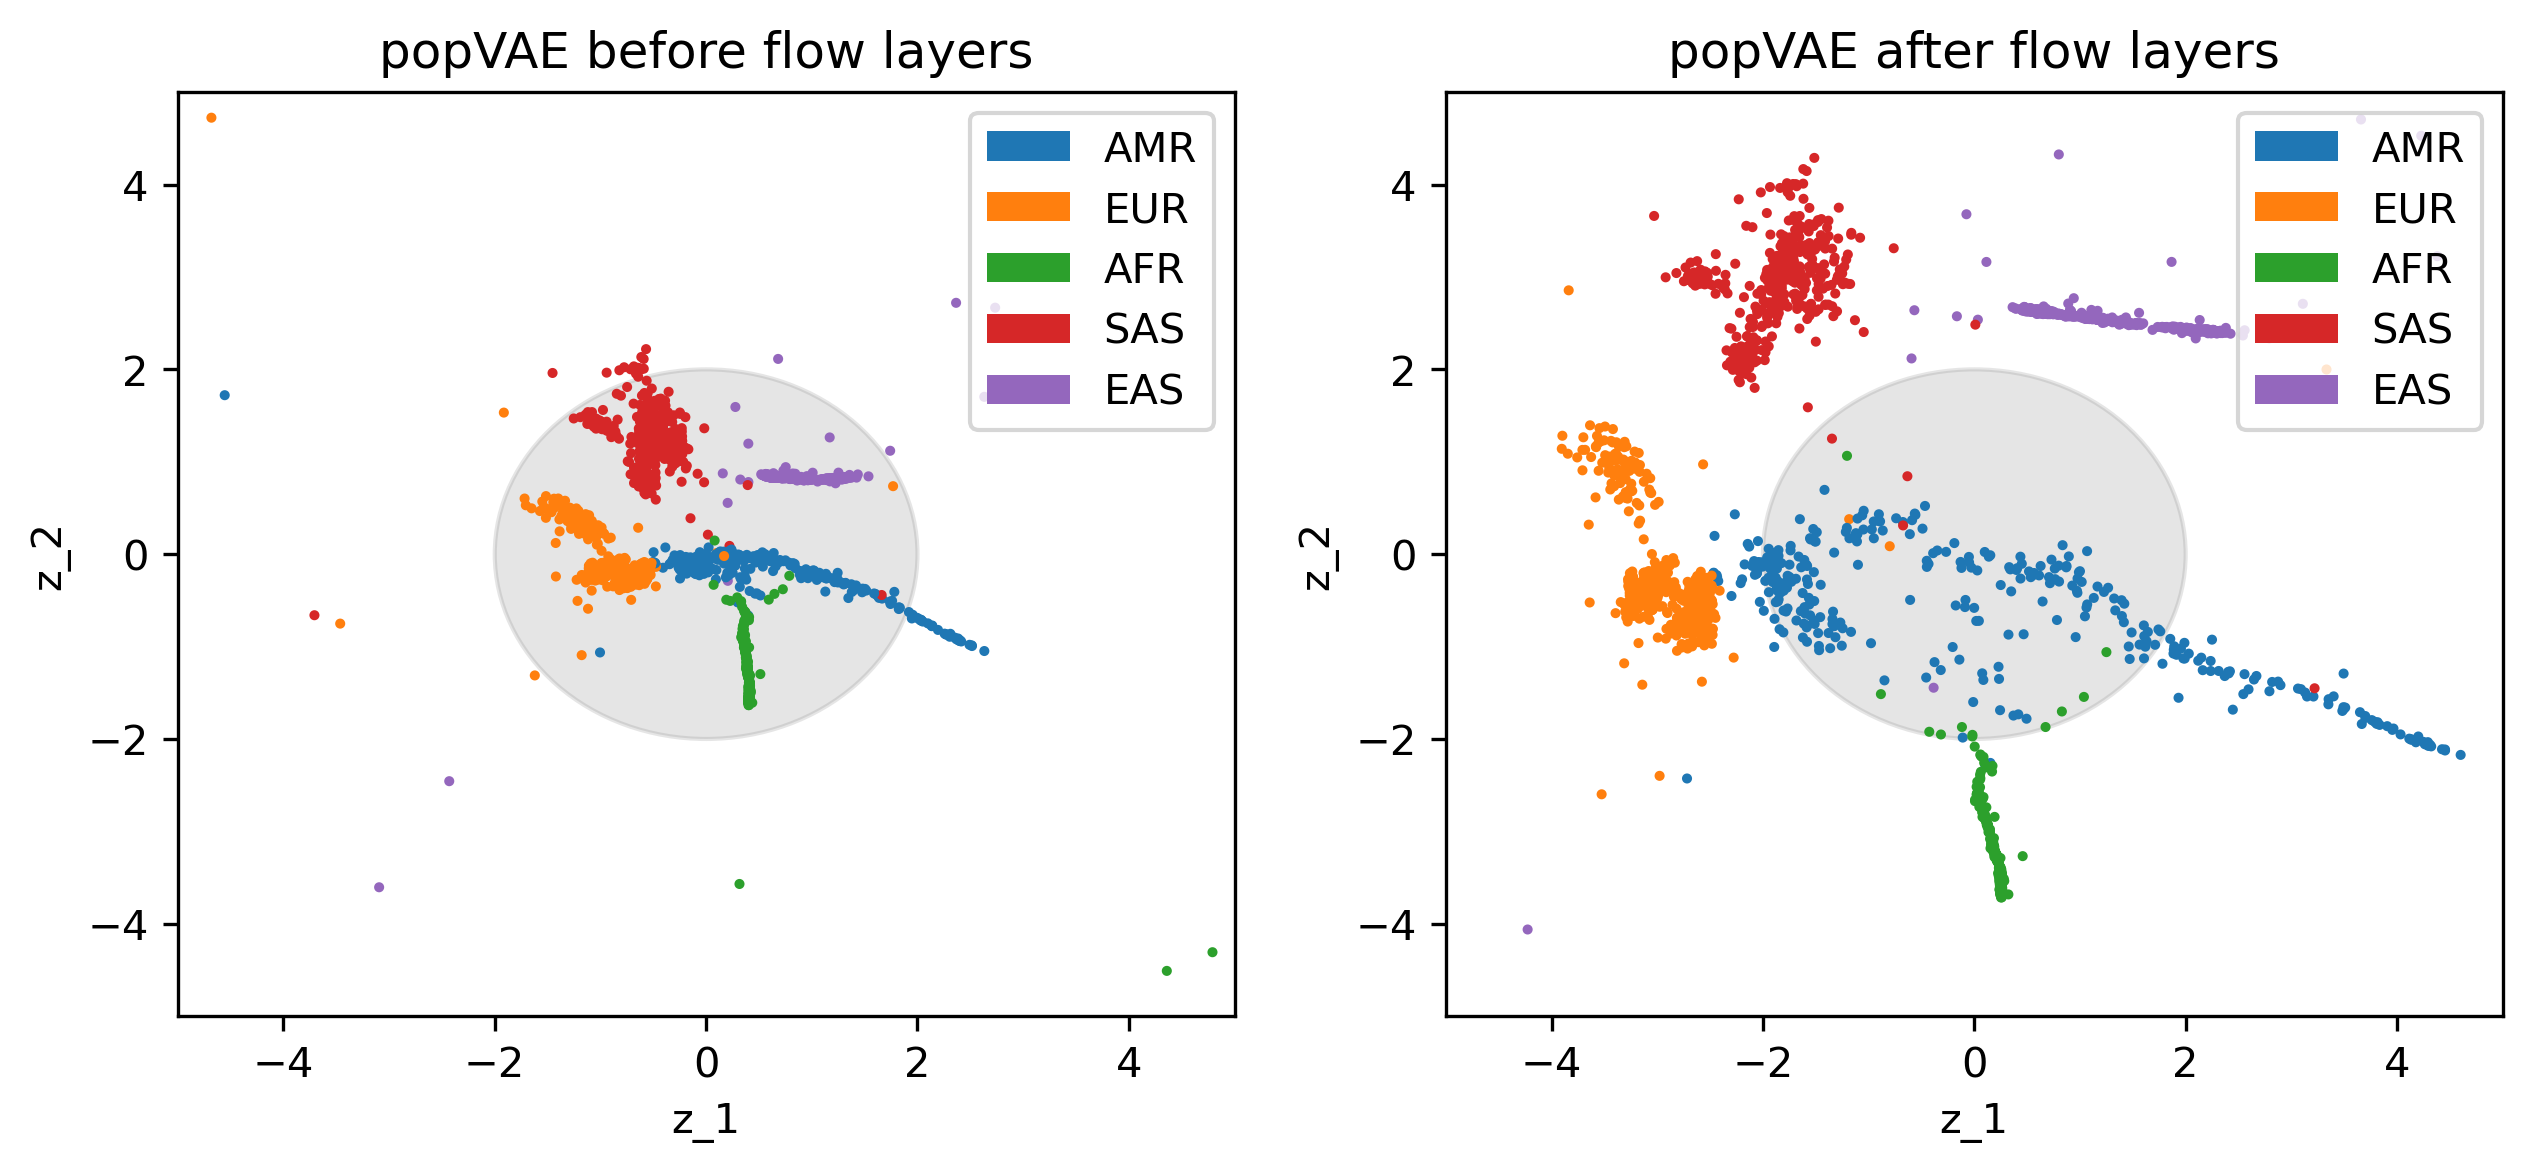

In [38]:
#%% Test trained vae
with torch.no_grad():
    vae = vae.to('cpu')
    vae.eval()
    data, labels = dataset[:]
    mean,logvar = vae.encoder(data)
    mean_transformed,log_Det = vae.flow(mean)
#%% Plot the output
mu = mean.numpy()
mu_f = mean_transformed.numpy()
palette = sns.color_palette()
colors = [palette[cmap[l]] for l in labels_1kg]
legend_elements =  [Patch(facecolor=palette[cmap[l]],label=l) for l in set(labels_1kg)]
prior = plt.Circle((0, 0), 2, color='gray', fill=True, alpha=0.2)

fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=300)
ax[0].add_patch(prior)
ax[0].scatter(mu[:,0],mu[:,1],color=colors,s=2)
ax[0].set_xlim(-5,5)
ax[0].set_ylim(-5,5)
ax[0].legend(handles = legend_elements, loc='upper right')
ax[0].set_title('popVAE before flow layers')
ax[0].set_xlabel('z_1')
ax[0].set_ylabel('z_2')

prior1 = plt.Circle((0, 0), 2, color='gray', fill=True, alpha=0.2)
ax[1].add_patch(prior1)
ax[1].scatter(mu_f[:,0],mu_f[:,1],color=colors,s=2)
ax[1].set_xlim(-5,5)
ax[1].set_ylim(-5,5)
ax[1].legend(handles = legend_elements, loc='upper right')
ax[1].set_title('popVAE after flow layers')
ax[1].set_xlabel('z_1')
ax[1].set_ylabel('z_2')
plt.show()

In [39]:
#%%# define the cvae model, evaluator and optimizer
from collections import defaultdict
# cVAE
latent_features = 2
hidden_layers = 5 
layer_widths = [1024,512,256,128,64]
cvae = VariationalAutoencoder(len(dataset[0][0]), 
                             latent_features,
                             hidden_layers,
                             width = (layer_widths,
                                      layer_widths[::-1]),
                             batch_norm=True,
                             flow=True,
                             nconditions=2)



# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch_cvae = 0

Finished epoch 40 with validation loss 5073504.0


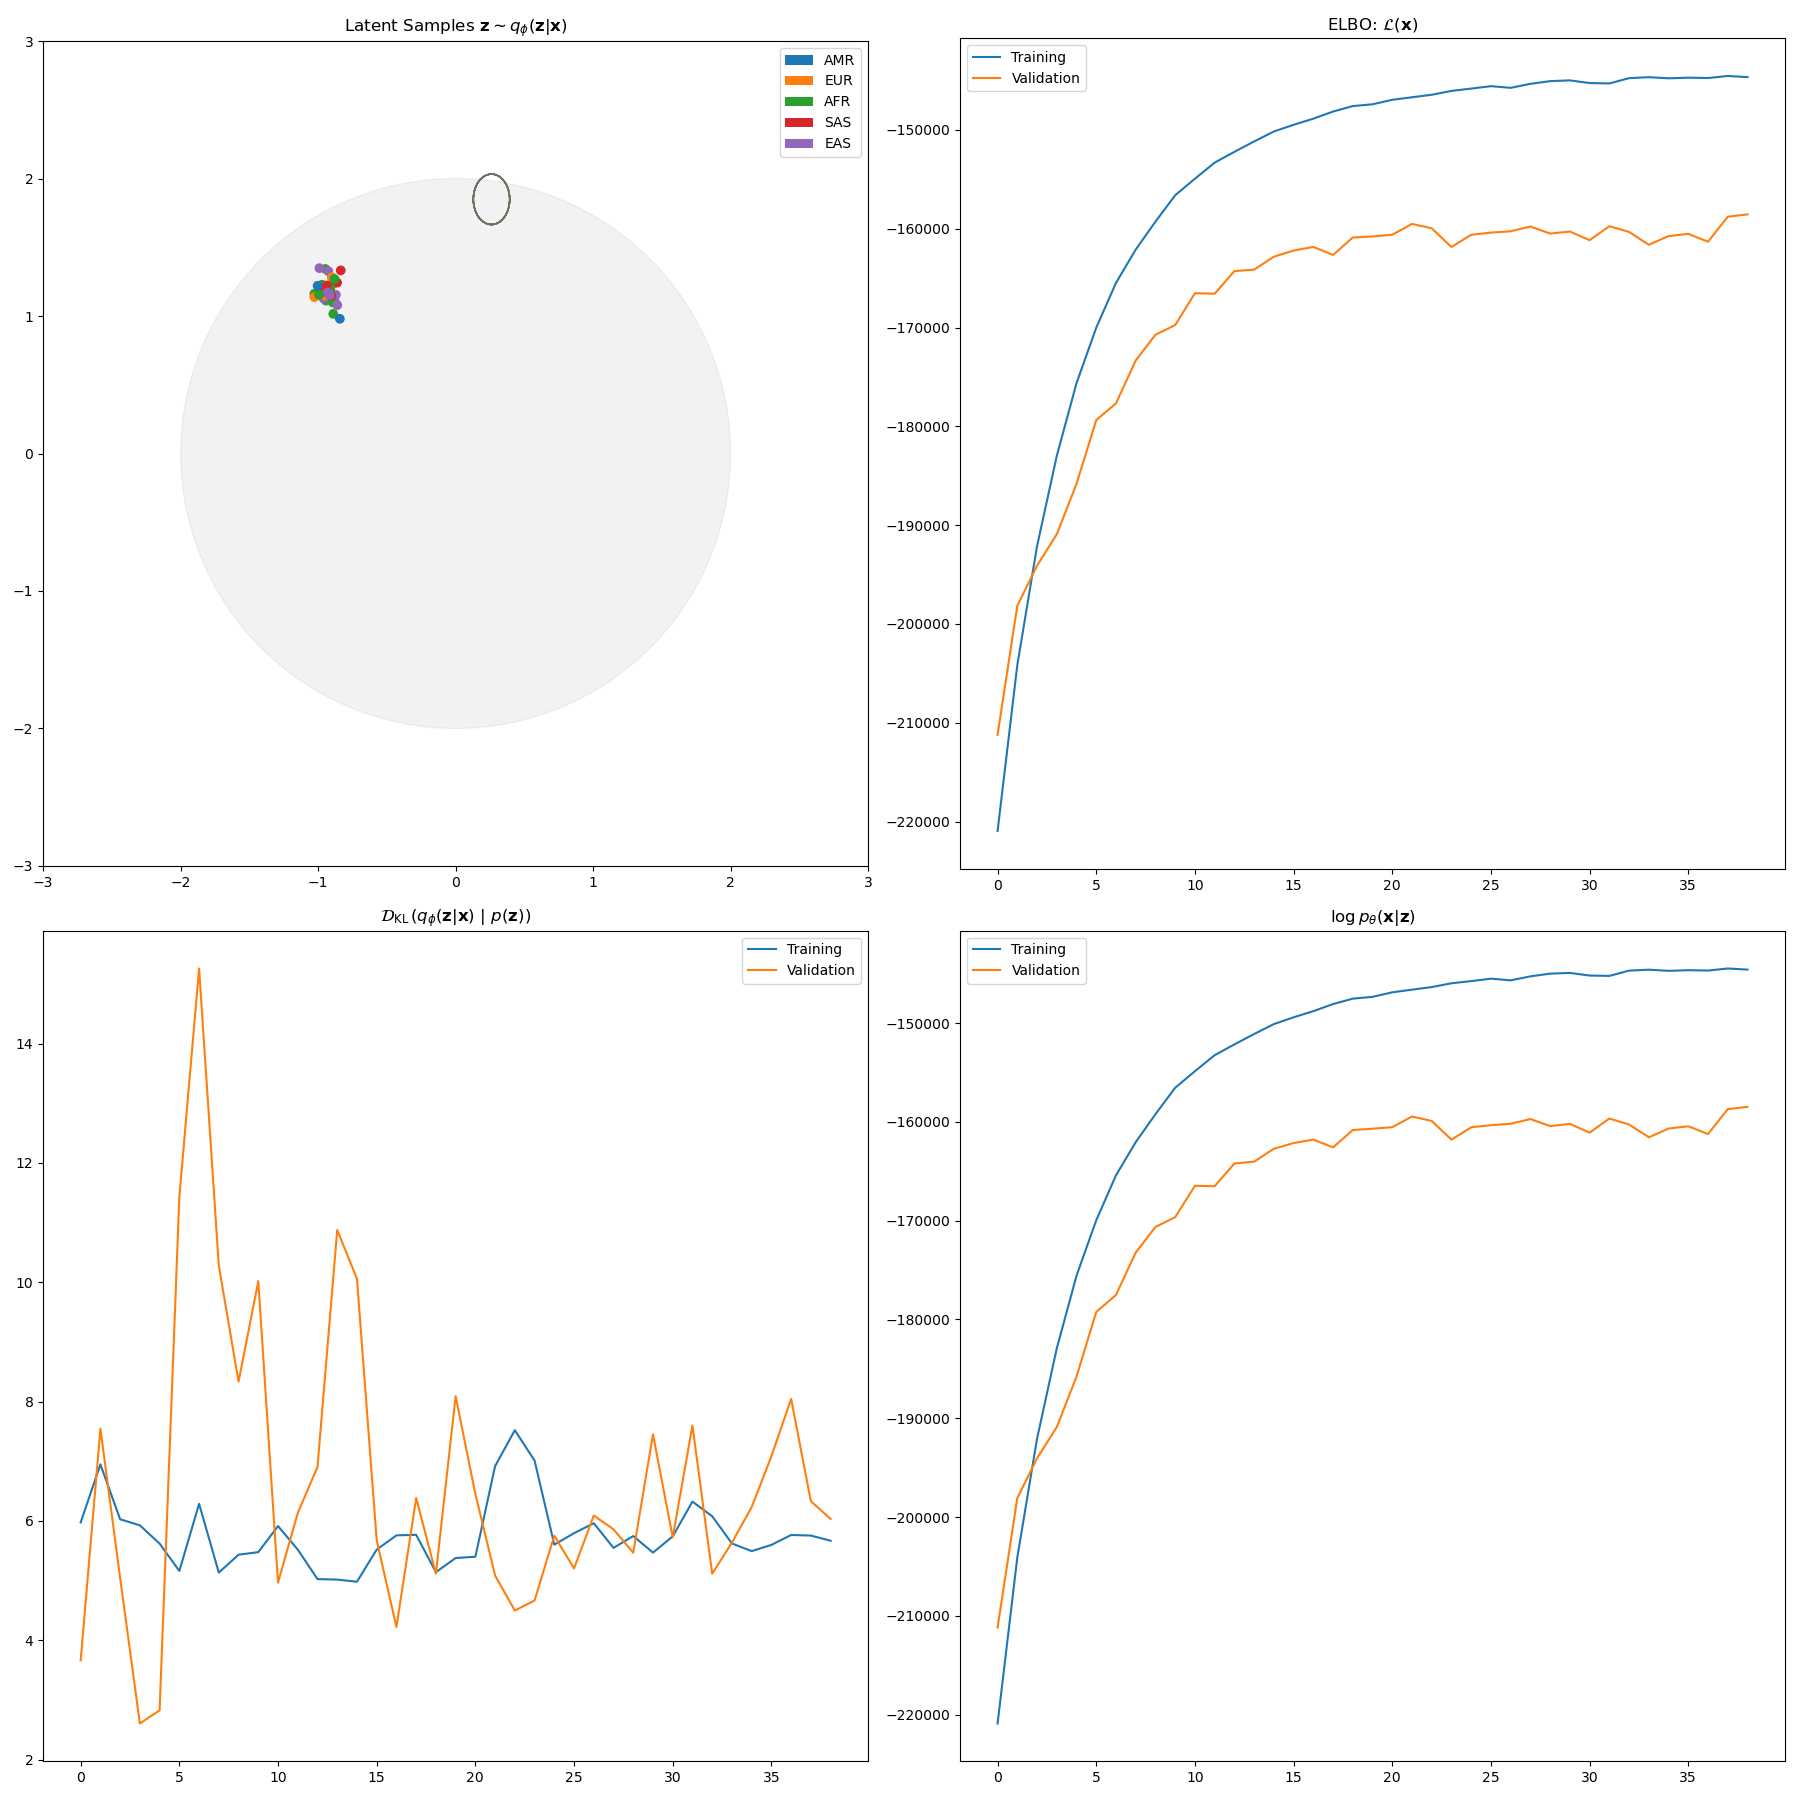

In [42]:
#cVAE training
num_epochs_cvae = 40

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f">> Using device: {device}")

# move the model to the device
cvae = cvae.to(device)
# Makesure the popVAE is on cpu
vae = vae.to('cpu')

# training..
while epoch_cvae < num_epochs_cvae:
    torch.cuda.empty_cache()
    epoch_cvae += 1
    training_epoch_data = defaultdict(list)
    cvae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        with torch.no_grad():
            vae.eval()
            mean,logvar = vae.encoder(x)
            conditions = vae.sample_posterior(mean,logvar)
            conditions,log_det = vae.flow(conditions)
            #conditions[conditions > 5] = 5
            
        x = x.to(device)
        conditions = conditions.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, outputs, diagnostics = cvae(x, y=conditions,beta=10)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.item()/len(x)]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        cvae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        with torch.no_grad():
            with torch.no_grad():
                vae.eval()
                mean,logvar = vae.encoder(x)
                conditions = vae.sample_posterior(mean,logvar)
                conditions,log_det = vae.flow(conditions)
            
        x = x.to(device)
        conditions = conditions.to(device)
        # perform a forward pass through the model and compute the ELBO
        loss, outputs, diagnostics = cvae(x,y=conditions,beta=10)
        outputs['qz'] = ReparameterizedDiagonalGaussian(outputs['mean'], 0.5*outputs['logvar'])
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.item()/len(x)]

        print(f"Finished epoch {epoch_cvae} with validation loss {loss}")
        # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
        make_vae_plots(cvae, x, y, outputs, training_data, validation_data, cmap=cmap)


In [43]:
save_cvae_2d = False
if save_cvae_2d:
    torch.save(cvae.state_dict(), 'cvae_2d.pt')

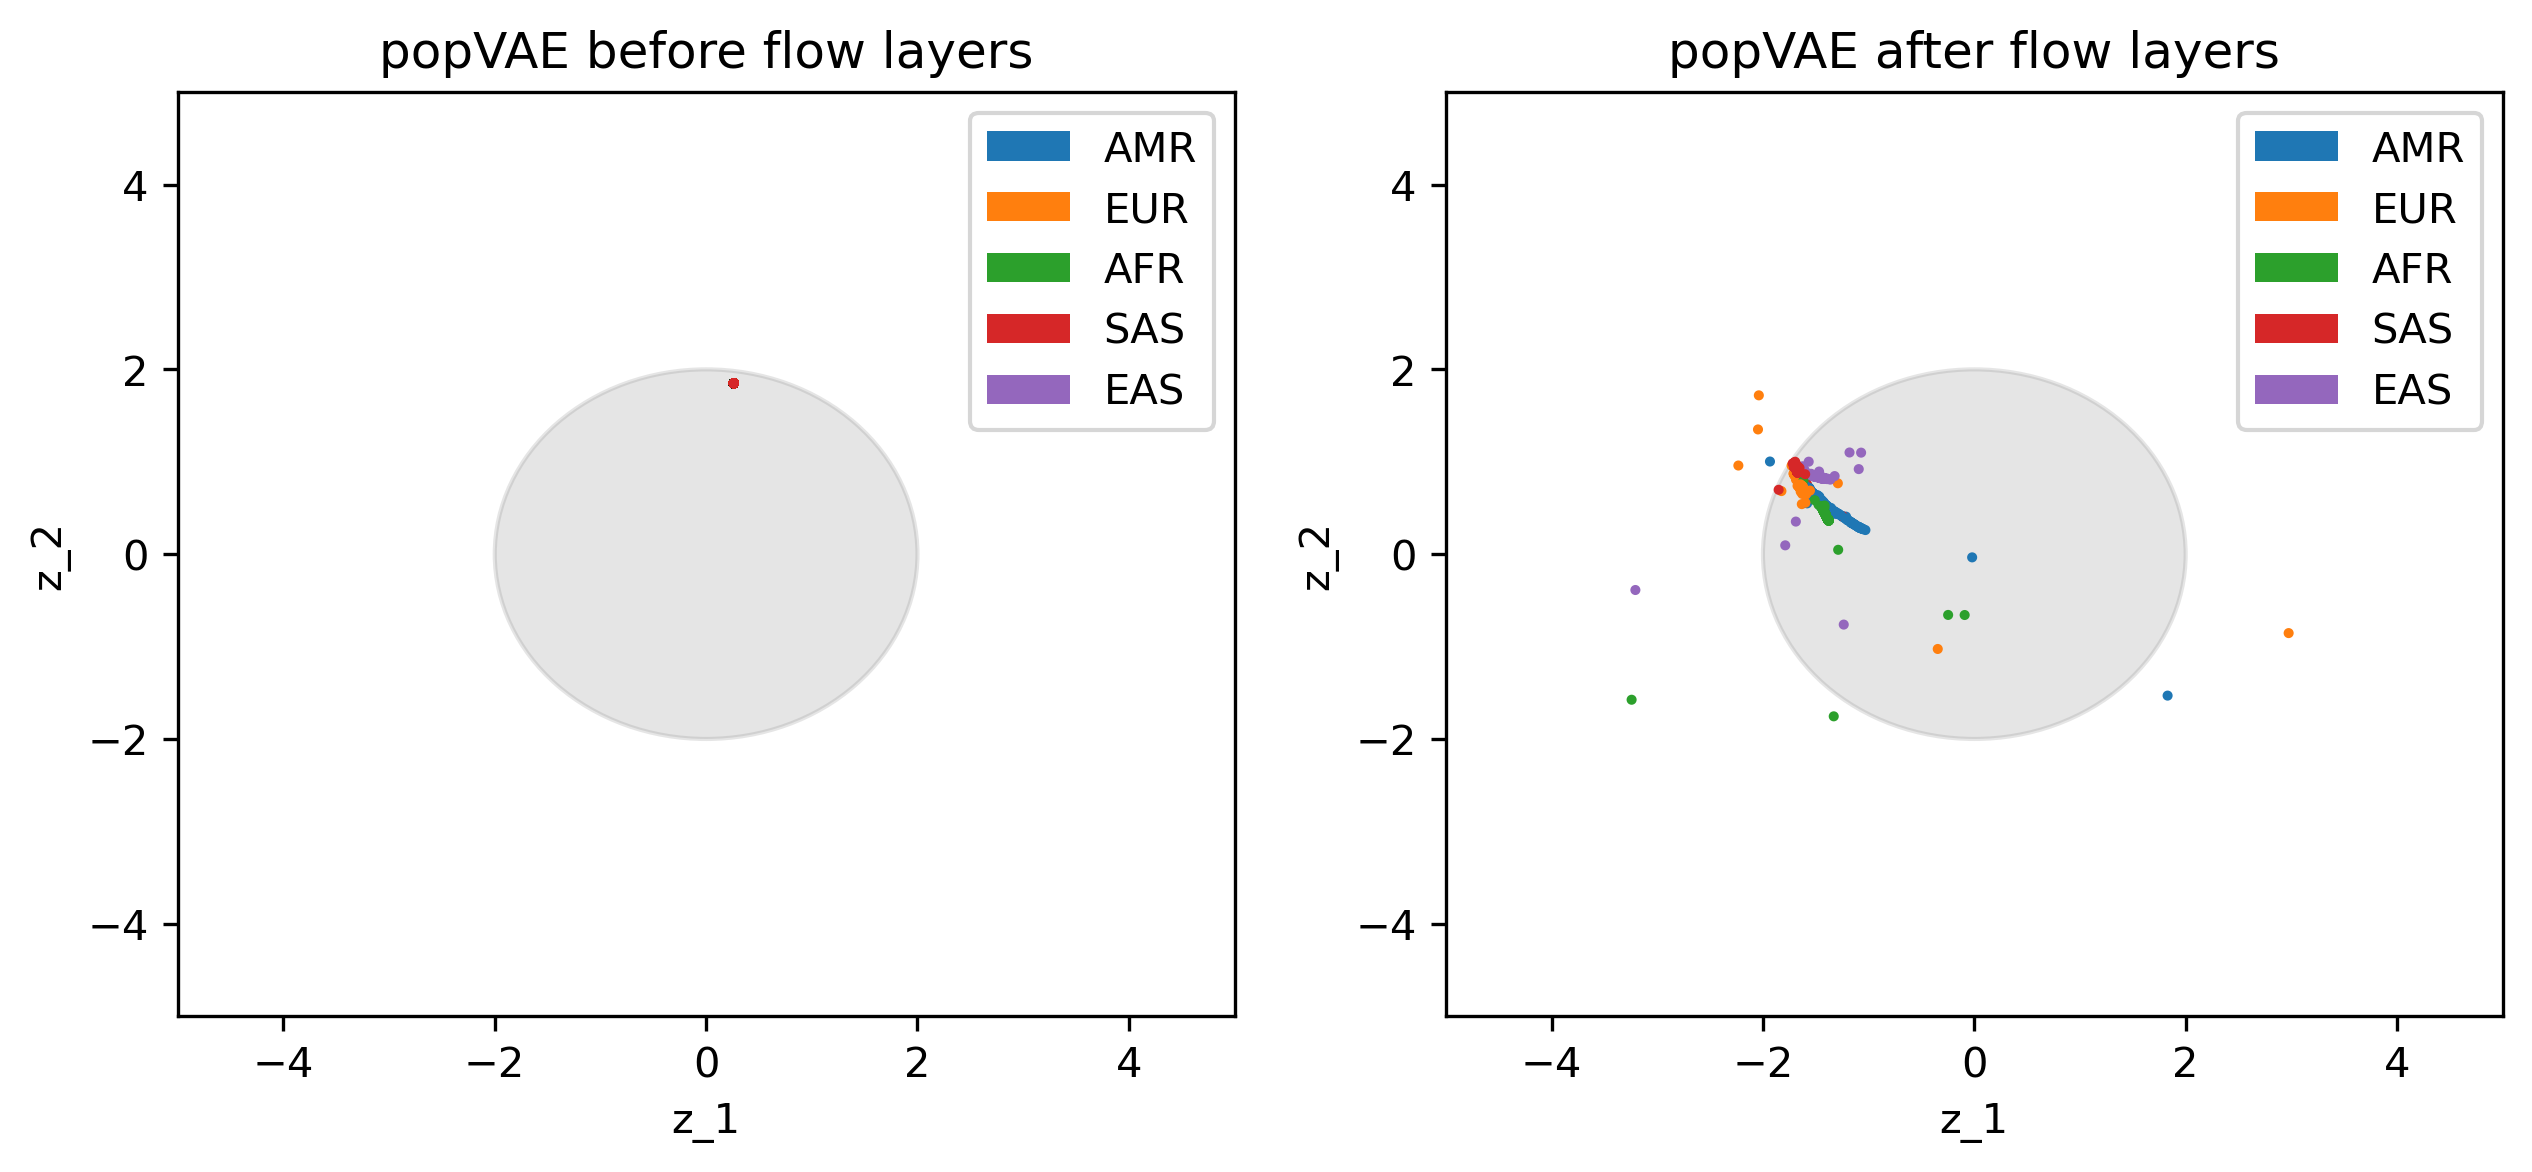

In [46]:
#%%
with torch.no_grad():
    vae = vae.to('cpu')
    vae.eval()
    data, labels = dataset[:]
    mean,logvar = vae.encoder(data)
    z = vae.sample_posterior(mean,logvar)
    z_t,log_det = vae.flow(z)
    cvae = cvae.to('cpu')
    mean, logvar = cvae.encoder(torch.cat([data,z_t], dim =1))
    mean_transformed, log_det = cvae.flow(mean_transformed)
    
#%% Plot the output
mu = mean.numpy()
mu_f = mean_transformed.numpy()
palette = sns.color_palette()
colors = [palette[cmap[l]] for l in labels_1kg]
legend_elements =  [Patch(facecolor=palette[cmap[l]],label=l) for l in set(labels_1kg)]
prior = plt.Circle((0, 0), 2, color='gray', fill=True, alpha=0.2)

fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=300)
ax[0].add_patch(prior)
ax[0].scatter(mu[:,0],mu[:,1],color=colors,s=2)
ax[0].set_xlim(-5,5)
ax[0].set_ylim(-5,5)
ax[0].legend(handles = legend_elements, loc='upper right')
ax[0].set_title('cVAE before flow layers')
ax[0].set_xlabel('z_1')
ax[0].set_ylabel('z_2')

prior1 = plt.Circle((0, 0), 2, color='gray', fill=True, alpha=0.2)
ax[1].add_patch(prior1)
ax[1].scatter(mu_f[:,0],mu_f[:,1],color=colors,s=2)
ax[1].set_xlim(-5,5)
ax[1].set_ylim(-5,5)
ax[1].legend(handles = legend_elements, loc='upper right')
ax[1].set_title('cVAE after flow layers')
ax[1].set_xlabel('z_1')
ax[1].set_ylabel('z_2')
plt.show()

In [48]:
#%%# define the cvae model, evaluator and optimizer
from collections import defaultdict
# cVAE
latent_features = 32
hidden_layers = 5 
layer_widths = [1024,512,256,128,64]
cvae = VariationalAutoencoder(len(dataset[0][0]), 
                             latent_features,
                             hidden_layers,
                             width = (layer_widths,
                                      layer_widths[::-1]),
                             batch_norm=True,
                             flow=True,
                             nconditions=2)



# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch_cvae = 0

Finished epoch 40 with validation loss 5101448.0


C:\Users\Niels\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Niels\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


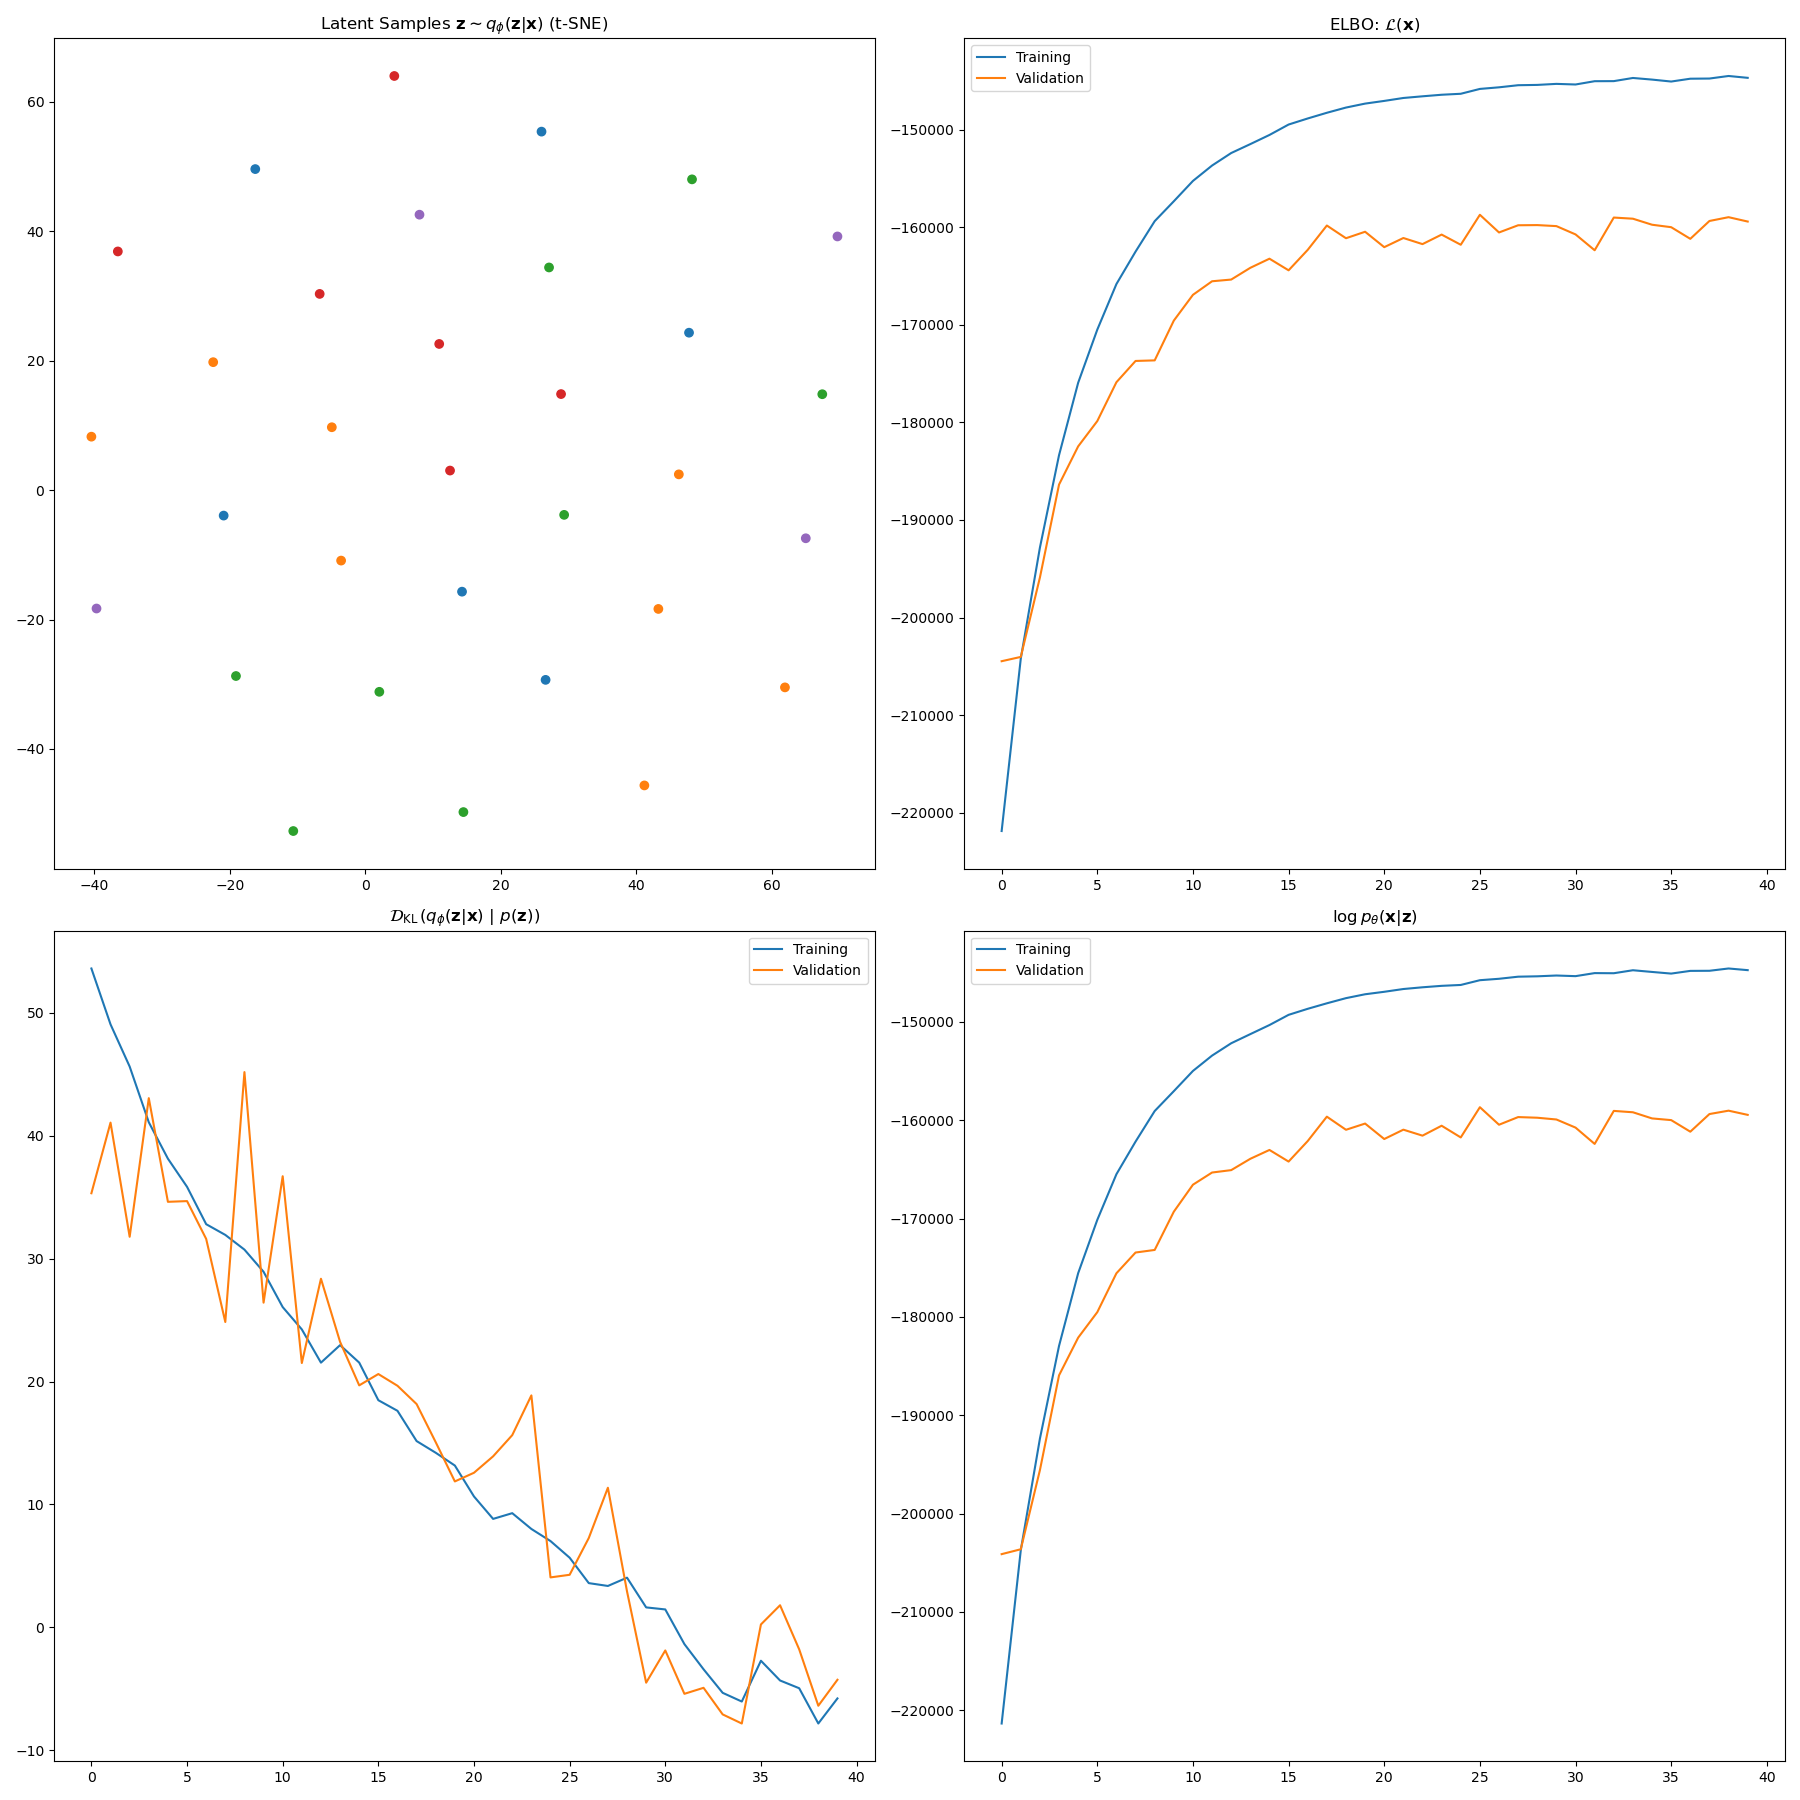

In [49]:
#cVAE training
num_epochs_cvae = 40

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f">> Using device: {device}")

# move the model to the device
cvae = cvae.to(device)
# Makesure the popVAE is on cpu
vae = vae.to('cpu')

# training..
while epoch_cvae < num_epochs_cvae:
    torch.cuda.empty_cache()
    epoch_cvae += 1
    training_epoch_data = defaultdict(list)
    cvae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        with torch.no_grad():
            vae.eval()
            mean,logvar = vae.encoder(x)
            conditions = vae.sample_posterior(mean,logvar)
            conditions,log_det = vae.flow(conditions)
            #conditions[conditions > 5] = 5
            
        x = x.to(device)
        conditions = conditions.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, outputs, diagnostics = cvae(x, y=conditions,beta=10)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.item()/len(x)]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        cvae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        with torch.no_grad():
            with torch.no_grad():
                vae.eval()
                mean,logvar = vae.encoder(x)
                conditions = vae.sample_posterior(mean,logvar)
                conditions,log_det = vae.flow(conditions)
            
        x = x.to(device)
        conditions = conditions.to(device)
        # perform a forward pass through the model and compute the ELBO
        loss, outputs, diagnostics = cvae(x,y=conditions,beta=10)
        outputs['qz'] = ReparameterizedDiagonalGaussian(outputs['mean'], 0.5*outputs['logvar'])
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.item()/len(x)]

        print(f"Finished epoch {epoch_cvae} with validation loss {loss}")
        # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
        make_vae_plots(cvae, x, y, outputs, training_data, validation_data, cmap=cmap)

In [50]:
save_cvae_32d = False
if save_cvae_32d:
    torch.save(cvae.state_dict(), 'cvae_32d.pt')

In [51]:
#load AD-dataset
data_adgwas = np.load('data_adgwas.npy')
labels_adgwas = np.load('labels_adgwas.npy')
#clean out missing snps (replace -1 with a draw of 0,1 or 2 based on the allele freqs)
missing_idx = np.argwhere(data_adgwas  == -1)
for idx in np.unique(missing_idx[:,1]):
    col = data_adgwas[:,idx]
    col_clean = col[col!=-1]
    freq = col_clean.sum()/(2*len(col))
    draw = np.random.binomial(2, freq)   
    col[col == -1] = draw
    data_adgwas[:,idx] = col

In [52]:
#Making training and test sets
dataset = snp_Dataset(data_adgwas,labels_adgwas)
size_test = round(len(dataset)*25/100)
size_train = len(dataset)-size_test
train_data, test_data = random_split(dataset, [size_train, size_test])

In [53]:
# Make data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16,
                                           shuffle = True, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32,
                                           shuffle = True, num_workers = 0)